In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd

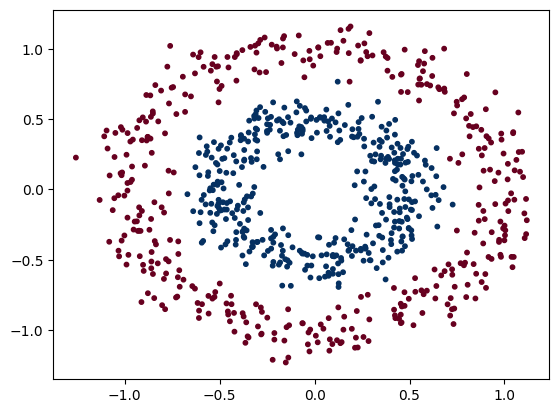

In [3]:
# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

In [4]:
# Define the overly complicated MLP
# class LargeMLP(nn.Module):
#     def __init__(self):
#         super(LargeMLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(2, 5),
#             nn.ReLU(),
#             nn.Linear(5, 6),
#             nn.ReLU(),
#             nn.Linear(6, 5),
#             nn.ReLU(),
#             nn.Linear(5, 7),
#             nn.ReLU(),
#             nn.Linear(7, 2),
#             # nn.ReLU()
#         )

#     def forward(self, x):
#         model.layers()
#         return self.layers(x)

model = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 7),
    nn.ReLU(),
    nn.Linear(7, 6),
    nn.ReLU(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.Sigmoid()
)

print(model)
model_cpy = copy.deepcopy(model)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=2, bias=True)
  (9): Sigmoid()
)


In [4]:
for name, param in model.named_parameters():
	if param.requires_grad:
		print(param)

Parameter containing:
tensor([[ 0.3382, -0.6957],
        [-0.1486,  0.2217],
        [ 0.3603,  0.3440],
        [-0.0032, -0.6332],
        [ 0.0136,  0.6769]], requires_grad=True)
Parameter containing:
tensor([ 0.5646,  0.6335,  0.1460,  0.3043, -0.1450], requires_grad=True)
Parameter containing:
tensor([[ 0.2077,  0.4178,  0.4031,  0.0231,  0.2140],
        [ 0.0334,  0.3978, -0.4160,  0.2997,  0.0896],
        [-0.1152,  0.2539,  0.1518,  0.1578, -0.3479],
        [-0.1225, -0.4322,  0.0526,  0.3991, -0.2064],
        [ 0.3462, -0.3894,  0.1630, -0.2175, -0.1229],
        [ 0.2411,  0.1347,  0.0924,  0.4300, -0.1949],
        [ 0.4151, -0.3516,  0.2314,  0.2753,  0.1713]], requires_grad=True)
Parameter containing:
tensor([-0.0620,  0.3260,  0.0512, -0.0187,  0.3519, -0.3021, -0.3462],
       requires_grad=True)
Parameter containing:
tensor([[-0.0300, -0.1238, -0.2398,  0.2010, -0.2485,  0.3522,  0.2554],
        [ 0.0595, -0.0129,  0.2867, -0.1616, -0.1034, -0.3119, -0.2802],
    

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.4239, Val Loss: 0.4353
Epoch [200/1000], Loss: 0.3428, Val Loss: 0.3595
Epoch [300/1000], Loss: 0.3299, Val Loss: 0.3435
Epoch [400/1000], Loss: 0.3244, Val Loss: 0.3402
Epoch [500/1000], Loss: 0.3214, Val Loss: 0.3413
Epoch [600/1000], Loss: 0.3201, Val Loss: 0.3409
Epoch [700/1000], Loss: 0.3189, Val Loss: 0.3408
Epoch [800/1000], Loss: 0.3181, Val Loss: 0.3387
Epoch [900/1000], Loss: 0.3175, Val Loss: 0.3377
Epoch [1000/1000], Loss: 0.3170, Val Loss: 0.3370


In [6]:
torch.save(model.state_dict(), 'model.pickle')

In [7]:
# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.98

In [8]:
# # Apply L1 structured pruning
# from torch.nn.utils import prune

# # Specify the amount of pruning
# amount = 0.5

# # Prune the model
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)

# # Print sparsity of each layer
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         print(f"Sparsity in {module}: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")


In [9]:
prune_ratio = 0.2
pruned_model = nn.Sequential()
pruned_layers = []
input_shape = 2
layer_index = 0
for name, param in model.named_parameters():
	if 'weight' in name:
		if param.shape[0] == 2:
			layer = nn.Linear(input_shape, 2)
			with torch.no_grad():
				layer.data = model_cpy[layer_index].weight.data
			pruned_layers.append(layer)
			pruned_layers.append(nn.Sigmoid())
			continue
		sorted_layers = torch.linalg.norm(param.data, ord=1, dim=1).argsort(dim=-1)
		print(sorted_layers)
		layers_not_pruned = sorted(sorted_layers[int(prune_ratio*param.data.shape[0]):])
		print(layers_not_pruned)
		#layer_data = param.data[layers_not_pruned,:]
		layer_data = model_cpy[layer_index].weight.data[layers_not_pruned, :] #initialising unpruned neurons with pre-trainied values
		layer = nn.Linear(input_shape, layer_data.shape[0])
		input_shape = layer_data.shape[0]
		with torch.no_grad():
			layer.data = layer_data
		pruned_layers.append(layer)
		pruned_layers.append(nn.ReLU())
		layer_index=layer_index+2	#skipping every alternate relu layer

print(pruned_layers)
pruned_model = nn.Sequential(*pruned_layers)
print(pruned_model[0].data)

tensor([1, 0, 3, 2, 4])
[tensor(0), tensor(2), tensor(3), tensor(4)]
tensor([0, 2, 1, 5, 4, 6, 3])
[tensor(1), tensor(2), tensor(3), tensor(4), tensor(5), tensor(6)]
tensor([3, 4, 5, 1, 2, 0])
[tensor(0), tensor(1), tensor(2), tensor(4), tensor(5)]
tensor([3, 0, 1, 2])
[tensor(0), tensor(1), tensor(2), tensor(3)]
[Linear(in_features=2, out_features=4, bias=True), ReLU(), Linear(in_features=4, out_features=6, bias=True), ReLU(), Linear(in_features=6, out_features=5, bias=True), ReLU(), Linear(in_features=5, out_features=4, bias=True), ReLU(), Linear(in_features=4, out_features=2, bias=True), Sigmoid()]
tensor([[ 0.3382, -0.6957],
        [ 0.3603,  0.3440],
        [-0.0032, -0.6332],
        [ 0.0136,  0.6769]])


In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pruned_model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # model.train()
    outputs = pruned_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        pruned_model.eval()
        with torch.no_grad():
            val_outputs = pruned_model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.5229, Val Loss: 0.5394
Epoch [200/1000], Loss: 0.3195, Val Loss: 0.3425
Epoch [300/1000], Loss: 0.3168, Val Loss: 0.3389
Epoch [400/1000], Loss: 0.3162, Val Loss: 0.3390
Epoch [500/1000], Loss: 0.3159, Val Loss: 0.3392
Epoch [600/1000], Loss: 0.3157, Val Loss: 0.3392
Epoch [700/1000], Loss: 0.3150, Val Loss: 0.3391
Epoch [800/1000], Loss: 0.3149, Val Loss: 0.3430
Epoch [900/1000], Loss: 0.3147, Val Loss: 0.3386
Epoch [1000/1000], Loss: 0.3145, Val Loss: 0.3445


In [11]:
# torch.unique(model(X_val_tensor))
y_val_outputs = pruned_model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.965

# Regression, Reliability

Epoch [100/1000], Loss: 56.5023, Val Loss: 55.7497
Epoch [200/1000], Loss: 12.7560, Val Loss: 12.5531
Epoch [300/1000], Loss: 2.8418, Val Loss: 2.8078
Epoch [400/1000], Loss: 1.4394, Val Loss: 1.4358
Epoch [500/1000], Loss: 1.3041, Val Loss: 1.3037
Epoch [600/1000], Loss: 1.2801, Val Loss: 1.2799
Epoch [700/1000], Loss: 1.2621, Val Loss: 1.2619
Epoch [800/1000], Loss: 1.2448, Val Loss: 1.2447
Epoch [900/1000], Loss: 1.2284, Val Loss: 1.2283
Epoch [1000/1000], Loss: 1.2132, Val Loss: 1.2130


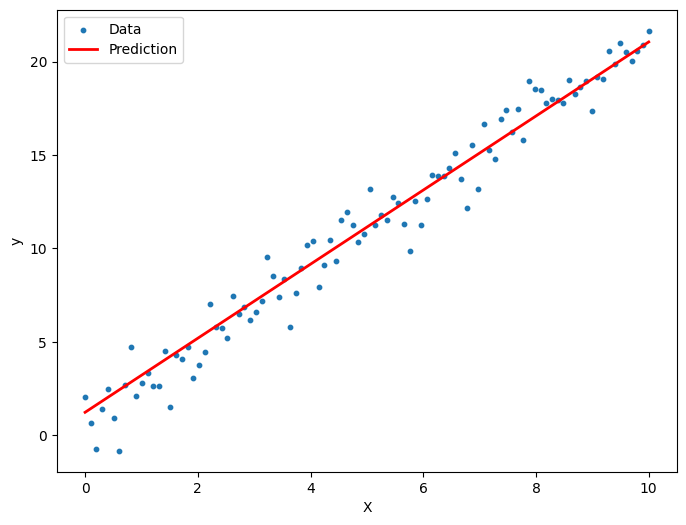

In [10]:
# Linear Regression dataset using PyTorch tensors
X = np.linspace(0, 10, 100)
y = 2*X + 1 + np.random.normal(0, 1, *X.shape)

# NN model for linear Regression
model = nn.Sequential(
    nn.Linear(1, 1)
)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X.reshape(-1, 1))
y_train_tensor = torch.FloatTensor(y.reshape(-1, 1))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_train_tensor)
            val_loss = criterion(val_outputs, y_train_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot the data and the model prediction
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10, label='Data')
plt.plot(X, model(X_train_tensor).detach().numpy(), color='red', linewidth=2, label='Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

0     0.797956
1     0.221351
2     0.009303
3     0.336752
4     0.677498
        ...   
95    0.602133
96    0.331195
97    0.466909
98    0.517722
99    0.725791
Name: perc, Length: 100, dtype: float64
0     0.834341
1    -0.767639
2    -2.353344
3    -0.421344
4     0.460715
        ...   
95    0.258871
96   -0.436615
97   -0.083042
98    0.044437
99    0.600132
Name: z, Length: 100, dtype: float64


AttributeError: 'Figure' object has no attribute 'close'

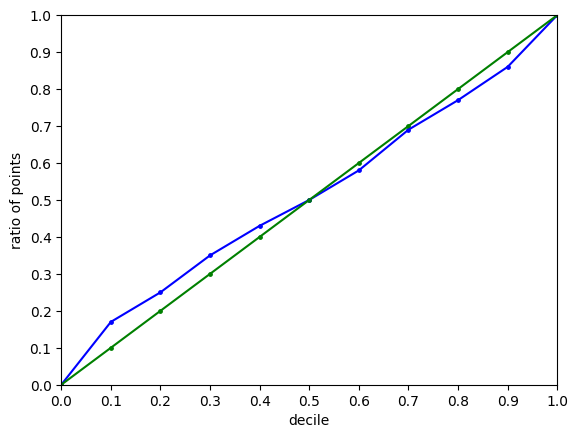

In [53]:
import scipy.stats as st

def reliability_diagram(mean, sigma, Y, color="blue", label="Model", marker_size=6):
    fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    print(df["perc"])
    print(df["z"])
    k = np.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")
    fig.close()

predictions = model(X_train_tensor).detach().numpy().reshape(-1,)
# print(predictions)
# y_pred = y_pred.detach().numpy()

true_labels = y_train_tensor.detach().numpy().reshape(-1,)
# print(true_labels)

sigma = np.ones((len(predictions),))

reliability_diagram(predictions, sigma, true_labels)
plt.show()


In [52]:
import scipy.stats as st

st.norm.ppf(0.9**0.5)

1.6322187896168658